## 1. Library Imports


In this section, we import all the necessary libraries for data preprocessing, tokenization, model training, and evaluation.


In [ ]:
import pandas as pd
import random
from typing import List, Tuple, Dict, Any
from transformers import BertTokenizer, BertForPreTraining, PreTrainedTokenizer, get_linear_schedule_with_warmup
import nltk
from nltk.tokenize import sent_tokenize
from tqdm import tqdm  # to create a progress bar during the train
import torch
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader
import time
import matplotlib.pyplot as plt
import os
import yaml

nltk.download("punkt_tab")

Mounted at /content/drive


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

# Preparation of dataset to compute DAPT



To prepare the dataset for NSP, for each abstract, we generate two sentence pairs used in the Next Sentence Prediction (NSP) task.

- **Positive pairs (label 0)**: Two consecutive sentences from the same abstract.
- **Negative pairs (label 1)**: Two non-consecutive sentences (from the same abstract or different abstracts).

This setup simulates the original NSP objective from BERT’s pre-training, where the model learns to predict whether a given sentence B logically follows sentence A.

The sentence pairs are tokenized using the BERT tokenizer. We apply the following settings:

- `sentence_a`, `sentence_b`: the input sentence pairs.
- `return_tensors="pt"`: returns the output as PyTorch tensors.
- `max_length=512`: maximum sequence length accepted by BERT.
- `truncation=True`: truncates longer pairs to fit the model’s limit.
- `padding="max_length"`: ensures all sequences are padded to the same length.

This step converts raw text into model-readable inputs (input IDs, attention masks, and token type IDs) required for pretraining tasks.

To compute tokenizatio e segmentation for MLM the abstracts are first split into sentences and tokenized with BERT’s tokenizer, adding the special tokens `[CLS]` at the start and `[SEP]` at the end of each sentence.

Since BERT has a maximum sequence length of 512 tokens, we segment longer token sequences into overlapping chunks of 512 tokens, with a stride of 462 tokens (512 - 50) to maintain some context overlap between segments.

Each chunk is padded to the maximum length, and attention masks and token type IDs are created accordingly. The output is a dictionary of tensors ready for input into the BERT model.

In the traditional BERT pre-training procedure, 15% of the tokens are selected for masking. Among those:

- 80% are replaced with the special `[MASK]` token.
- 10% are replaced with a random token from the vocabulary.
- 10% remain unchanged.

This stochastic masking strategy prevents the model from relying too heavily on the presence of `[MASK]` during training, improving its robustness for downstream tasks.



In [ ]:
class DataPreparation:
    """
    Prepares data for BERT-style pretraining tasks, including Next Sentence Prediction (NSP)
    and Masked Language Modeling (MLM), from a dataset of text abstracts.

    This class supports creating positive and negative NSP pairs, tokenizing sentence pairs,
    segmenting abstracts into overlapping BERT-compatible chunks, and applying BERT-style token masking.

    Attributes:
        df (pd.DataFrame): DataFrame containing abstracts with a column 'abstract_clean'.
        tokenizer (PreTrainedTokenizer): HuggingFace tokenizer compatible with BERT.
        max_length (int): Maximum token length for BERT inputs.
        mask_prob (float): Probability of masking tokens for MLM.
        sentence_a (List[str]): First sentence in NSP pair.
        sentence_b (List[str]): Second sentence in NSP pair.
        nsp_labels (List[int]): NSP labels: 0 for positive (consecutive), 1 for negative pairs.
    """
    def __init__(self, dataframe: pd.DataFrame, tokenizer: PreTrainedTokenizer,
                 max_length: int = 512, mask_prob: float = 0.15):
        self.df = dataframe
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.mask_prob = mask_prob
        self.sentence_a: List[str] = []
        self.sentence_b: List[str] = []
        self.nsp_labels: List[int] = []

    def _get_consecutive_sentences(self, sentences: List[str]) -> Tuple[str, str]:
        """Selects a consecutive pair of sentences from a list."""
        if len(sentences) == 2:
            return sentences[0], sentences[1]
        start = random.randint(0, len(sentences) - 2)
        return sentences[start], sentences[start + 1]

    def _get_negative_same_abstract(self, sentences: List[str]) -> Tuple[str, str]:
        """Creates a non-consecutive sentence pair from the same abstract."""
        a_idx = random.randint(0, len(sentences) - 1)
        non_consecutive = [i for i in range(len(sentences)) if (i < a_idx) or (i - a_idx > 1)]
        b_idx = random.choice(non_consecutive)
        return sentences[a_idx], sentences[b_idx]

    def _get_negative_cross_abstract(self, sentences: List[str], current_idx: int) -> Tuple[str, str]:
        """Creates a sentence pair where the second sentence is from a different abstract."""
        a = random.choice(sentences)
        other_idx = random.choice(list(range(current_idx)) + list(range(current_idx + 1, self.df.shape[0])))
        other_sentences = sent_tokenize(self.df.loc[other_idx, "abstract_clean"])
        b = random.choice(other_sentences)
        return a, b

    def create_nsp_examples(self, examples_per_abstract: int = 2) -> None:
        """
        Generates sentence pairs for Next Sentence Prediction (NSP) task.

        Args:
            examples_per_abstract (int): Number of NSP examples to create per abstract.
        """
        for idx, abstract in enumerate(self.df["abstract_clean"]):
            sentences = sent_tokenize(abstract)
            if len(sentences) < 2:
                continue

            for _ in range(examples_per_abstract):
                if random.random() < 0.5:
                    a, b = self._get_consecutive_sentences(sentences)
                    label = 0
                else:
                    if len(sentences) == 2:
                        a, b = sentences[1], sentences[0]
                    elif random.random() < 0.5:
                        a, b = self._get_negative_same_abstract(sentences)
                    else:
                        a, b = self._get_negative_cross_abstract(sentences, idx)
                    label = 1

                self.sentence_a.append(a)
                self.sentence_b.append(b)
                self.nsp_labels.append(label)

    def tokenize_nsp(self) -> Dict[str, torch.Tensor]:
        """
        Tokenizes NSP sentence pairs into BERT input format.

        Returns:
            Dict[str, torch.Tensor]: Dictionary containing input_ids, token_type_ids,
                                     attention_mask, and next_sentence_label.
        """
        encodings = self.tokenizer(self.sentence_a, self.sentence_b,
                                   return_tensors="pt", max_length=self.max_length,
                                   truncation=True, padding="max_length")
        encodings["next_sentence_label"] = torch.LongTensor(self.nsp_labels)
        return encodings

    def tokenize_and_segment_abstracts(self) -> Dict[str, Any]:
        """
        Segments abstracts into overlapping tokenized chunks for MLM training.

        Returns:
            dict: Dictionary containing:
                - input_ids (torch.Tensor): Tensor of token IDs with shape (num_segments, Max_length).
                - attention_mask (torch.Tensor): Attention masks for each segment.
                - token_type_ids (torch.Tensor): Token type IDs for each segment.
        """
        input_ids_all, attention_masks_all, token_type_ids_all = [], [], []

        for abstract in self.df["abstract_clean"]:
            sentences = sent_tokenize(abstract)
            token_ids = [self.tokenizer.cls_token_id]

            for sent in sentences:
                sent_ids = self.tokenizer.encode(sent, add_special_tokens=False)
                token_ids.extend(sent_ids + [self.tokenizer.sep_token_id])

            
            stride = self.max_length - 50
            i = 0

            while i < len(token_ids):

                chunk = token_ids[i:i + self.max_length]
                len_chunk = len(chunk)
                
                # Ensure CLS is at the beginning
                if chunk[0] != self.tokenizer.cls_token_id:
                    chunk = [self.tokenizer.cls_token_id] + chunk[:(len_chunk-1)]
                # Ensure SEP is at the end
                if chunk[-1] != self.tokenizer.sep_token_id:
                    chunk[-1]= self.tokenizer.sep_token_id
                pad_len = self.max_length - len_chunk

                chunk_padded = chunk + [self.tokenizer.pad_token_id] * pad_len
                attention_mask = [1] * len_chunk + [0] * pad_len
                token_type_ids = [0] * self.max_length

                input_ids_all.append(chunk_padded)
                attention_masks_all.append(attention_mask)
                token_type_ids_all.append(token_type_ids)
                
                i += stride

        return {
            "input_ids": torch.tensor(input_ids_all, dtype=torch.long),
            "attention_mask": torch.tensor(attention_masks_all, dtype=torch.long),
            "token_type_ids": torch.tensor(token_type_ids_all, dtype=torch.long),
        }

    def apply_bert_masking(self, features: Dict[str, torch.Tensor]) -> Dict[str, torch.Tensor]:
        """
        Applies BERT-style masking to input features for MLM task.

        Args:
            features (Dict[str, torch.Tensor]): Input dictionary containing 'input_ids'.

        Returns:
            Dict[str, torch.Tensor]: Updated input features with masked input and labels.
        """
        input_ids = features["input_ids"]
        masked_input_ids = input_ids.clone()
        labels = input_ids.clone()
        rand = torch.rand(input_ids.shape)

        mask_arr = (rand < self.mask_prob) & \
                   (input_ids != self.tokenizer.cls_token_id) & \
                   (input_ids != self.tokenizer.sep_token_id) & \
                   (input_ids != self.tokenizer.pad_token_id)

        labels[~mask_arr] = -100

        for i in range(mask_arr.shape[0]):
            token_indices = torch.nonzero(mask_arr[i]).flatten().tolist()
            for token_idx in token_indices:
                prob = random.random()
                if prob < 0.8:
                    masked_input_ids[i, token_idx] = self.tokenizer.mask_token_id
                elif prob < 0.9:
                    masked_input_ids[i, token_idx] = random.randint(0, self.tokenizer.vocab_size - 1)

        features["input_ids"] = masked_input_ids
        features["labels"] = labels
        return features

# Creation of Dataset

In [ ]:
class CombinedMLMNSPDataset(Dataset):
    """
    A custom PyTorch Dataset that combines data for both Masked Language Modeling (MLM)
    and Next Sentence Prediction (NSP) tasks. Each item returned contains all necessary
    fields for BERT-style pretraining.

    MLM examples will include 'labels' for token prediction and a dummy -100 value for
    'next_sentence_label'. NSP examples will contain 'next_sentence_label' and 'labels'
    filled with -100 to be ignored during MLM loss.

    Args:
        mlm_encodings (Dict[str, torch.Tensor]): Encoded inputs for the MLM task.
            Should include 'input_ids', 'attention_mask', 'token_type_ids', and 'labels'.
        nsp_encodings (Dict[str, torch.Tensor]): Encoded inputs for the NSP task.
            Should include 'input_ids', 'attention_mask', 'token_type_ids', and 'next_sentence_label'.

    Attributes:
        examples (List[Dict[str, torch.Tensor]]): A combined and shuffled list of training examples.
    """
    def __init__(self, mlm_encodings, nsp_encodings):
        self.examples = []

        # Add MLM examples with dummy -100 NSP label
        for i in range(len(mlm_encodings["input_ids"])):
            self.examples.append({
                "input_ids": mlm_encodings["input_ids"][i].detach().clone(),
                "attention_mask": torch.tensor(mlm_encodings["attention_mask"][i]).detach().clone(),
                "token_type_ids": torch.tensor(mlm_encodings["token_type_ids"][i]).detach().clone(),
                "labels": torch.tensor(mlm_encodings["labels"][i]).detach().clone(),
                "next_sentence_label": torch.tensor(-100)
            })

        # Add NSP examples with dummy -100 MLM labels
        for i in range(len(nsp_encodings["input_ids"])):
            input_ids = nsp_encodings["input_ids"][i].detach().clone()
            attention_mask = nsp_encodings["attention_mask"][i].detach().clone()
            token_type_ids = nsp_encodings["token_type_ids"][i].detach().clone()
            nsp_label = nsp_encodings["next_sentence_label"][i].detach().clone()
            labels = torch.full_like(input_ids, -100)

            self.examples.append({
                "input_ids": input_ids,
                "attention_mask": attention_mask,
                "token_type_ids": token_type_ids,
                "labels": labels,
                "next_sentence_label": nsp_label
            })
        # Shuffle to mix MLM and NSP examples
        random.shuffle(self.examples)

    def __len__(self):
        """Returns the total number of combined training examples."""
        return len(self.examples)

    def __getitem__(self, idx):
        """
        Retrieves a single training example at the specified index.

        Args:
            idx (int): Index of the item to retrieve.

        Returns:
            Dict[str, torch.Tensor]: Dictionary containing:
                - 'input_ids'
                - 'attention_mask'
                - 'token_type_ids'
                - 'labels'
                - 'next_sentence_label'
        """
        return self.examples[idx]


# Training of Model

In this section, we perform the training of the BERT model on both Masked Language Modeling (MLM) and Next Sentence Prediction (NSP) objectives simultaneously.

The training loop in the method  train terates over the dataset in mini-batches, transferring the inputs and labels to the computation device (CPU or GPU). For each batch, it computes the combined loss from both tasks, performs backpropagation, and updates the model parameters using the AdamW optimizer.

The use of the progress bar (via tqdm) allows real-time monitoring of the training process, displaying the current epoch and the loss value to track convergence.

In [ ]:
class DAPTTrainer:
    """
    A training utility for Domain-Adaptive Pretraining (DAPT) of BERT using both
    Masked Language Modeling (MLM) and Next Sentence Prediction (NSP) objectives.

    This trainer supports training from scratch or resuming from checkpoints,
    saving intermediate checkpoints, and adjusting learning rate with linear warmup scheduling.

    Attributes:
        model (BertForPreTraining): BERT model with MLM + NSP heads.
        dataset (Dataset): PyTorch dataset with combined MLM and NSP data.
        batch_size (int): Batch size used for training.
        epochs (int): Number of full training passes over the dataset.
        lr (float): Learning rate for AdamW optimizer.
        device (torch.device): Training device (CPU or CUDA).
        checkpoint_dir (str): Directory to store training checkpoints.
        checkpoint_interval (int): Interval in epochs to save checkpoints.
        dataloader (DataLoader): PyTorch DataLoader for the training dataset.
        optimizer (AdamW): Optimizer used for training.
        scheduler (Scheduler): Learning rate scheduler.
        start_epoch (int): Starting epoch (used when resuming training).
    """
    def __init__(
        self,
        model: BertForPreTraining,
        dataset: Dataset,
        batch_size: int = 16,
        epochs: int = 2,
        lr: float = 1e-5,
        device: torch.device = None,
        checkpoint_dir: str = "../checkpoints",
        checkpoint_interval: int = 1,
        resume_from_checkpoint: str = None,
    ):
        self.model = model
        self.dataset = dataset
        self.batch_size = batch_size
        self.epochs = epochs
        self.lr = lr
        self.device = device if device else torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.checkpoint_dir = checkpoint_dir
        self.checkpoint_interval = checkpoint_interval

        os.makedirs(self.checkpoint_dir, exist_ok=True)

        self.model.to(self.device)
        self.optimizer = AdamW(self.model.parameters(), lr=self.lr)
        self.dataloader = DataLoader(self.dataset, batch_size=self.batch_size, shuffle=True, drop_last=True)

        total_steps = len(self.dataloader) * self.epochs
        self.scheduler = get_linear_schedule_with_warmup(
            self.optimizer,
            num_warmup_steps=int(0.1 * total_steps),  # 10% warmup
            num_training_steps=total_steps
        )

        self.start_epoch = 0
        if resume_from_checkpoint:
            self._load_checkpoint(resume_from_checkpoint)
        self.model.train()

    def _save_checkpoint(self, epoch: int) -> None:
        """
        Saves model, optimizer, and scheduler state at the given epoch.

        Args:
            epoch (int): Current epoch number (1-based).
        """
        checkpoint_path = os.path.join(self.checkpoint_dir, f"dapt_checkpoint_epoch_{epoch}.pt")
        torch.save({
            'epoch': epoch,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'scheduler_state_dict': self.scheduler.state_dict()
        }, checkpoint_path)
        print(f"Checkpoint saved at epoch {epoch} at {checkpoint_path}")

    def _load_checkpoint(self, checkpoint_path: str) -> None:
        """
        Loads model, optimizer, and scheduler state from a checkpoint file.

        Args:
            checkpoint_path (str): Path to the checkpoint file (.pt).
        """
        checkpoint = torch.load(checkpoint_path, map_location=self.device)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        self.start_epoch = checkpoint['epoch'] + 1
        print(f"Resumed training from checkpoint at epoch {checkpoint['epoch']}")

    def train(self) -> None:
        """
        Executes the training loop across all epochs, with per-batch optimization,
        loss logging, learning rate scheduling, and checkpoint saving.
        """

        import time

        self.epoch_losses = []

        for epoch in range(self.start_epoch, self.epochs):
            epoch_start = time.time()
            loop = tqdm(self.dataloader, leave=True)
            total_loss = 0.0

            for batch in loop:
                self.optimizer.zero_grad()

                input_ids = batch["input_ids"].to(self.device)
                token_type_ids = batch["token_type_ids"].to(self.device)
                attention_mask = batch["attention_mask"].to(self.device)
                next_sentence_label = batch["next_sentence_label"].to(self.device)
                labels = batch["labels"].to(self.device)

                outputs = self.model(
                    input_ids,
                    token_type_ids=token_type_ids,
                    attention_mask=attention_mask,
                    next_sentence_label=next_sentence_label,
                    labels=labels
                )
                loss = outputs.loss
                loss.backward()
                self.optimizer.step()
                self.scheduler.step()

                total_loss += loss.item()
                loop.set_description(f"Epoch {epoch+1}/{self.epochs}")
                loop.set_postfix(loss=loss.item())

            avg_loss = total_loss / len(self.dataloader)
            self.epoch_losses.append(avg_loss)

            epoch_time = time.time() - epoch_start
            print(f"Epoch {epoch+1} completed in {epoch_time:.2f}s - Avg Loss: {avg_loss:.4f}")

            if (epoch + 1) % self.checkpoint_interval == 0:
                self._save_checkpoint(epoch + 1)

        print("Training finished.")

        plt.plot(range(1, len(self.epoch_losses) + 1), self.epoch_losses, marker='o')
        plt.xlabel("Epoch")
        plt.ylabel("Average Loss")
        plt.title("Training Loss per Epoch")
        plt.grid(True)
        plt.show()


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/tmp/ipython-input-3-2797537874.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "attention_mask": torch.tensor(mlm_encodings["attention_mask"][i]).detach().clone(),
/tmp/ipython-input-3-2797537874.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "token_type_ids": torch.tensor(mlm_encodings["token_type_ids"][i]).detach().clone(),
/tmp/ipython-input-3-2797537874.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "labels": torch.tensor(mlm_encodings["labels"][i]).detach().clone(),
Epoch 1/2: 100%|██████████| 3/3 [05:20<00:00, 106.

Epoch 1 completed in 320.59s - Avg Loss: 8.1441


Epoch 2/2: 100%|██████████| 3/3 [04:19<00:00, 86.53s/it, loss=3.65]


Epoch 2 completed in 259.60s - Avg Loss: 6.3036
Checkpoint saved at epoch 2 at ../checkpoints/dapt_checkpoint_epoch_2.pt
Training finished.


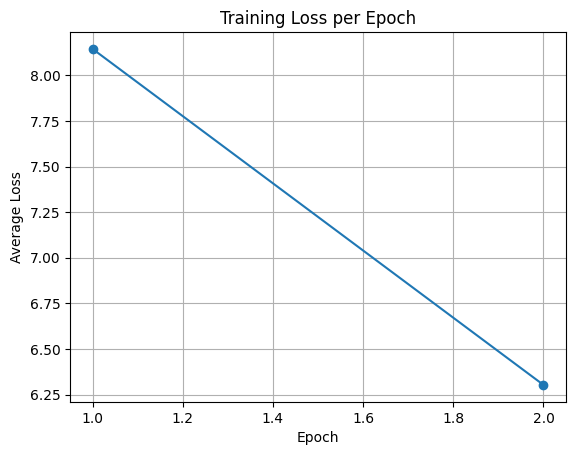


Total training time: 581.86 seconds (9.70 minutes)


In [ ]:
# 1. Load config from YAML
with open("../File_YAML/Esecuzione_DAPT_10K.yaml", "r") as f:
    config = yaml.safe_load(f)

# 2. Load dataset
sample_df = pd.read_csv(config["data_path"])

sample_df = sample_df.sample(n=16, random_state=42).reset_index(drop=True)

import pandas as pd

sample_df = {
    "abstract_clean": [
        "La pandemia ha cambiato il mondo. Le abitudini quotidiane sono mutate. Il lavoro da remoto è diventato la norma.",
        "L'intelligenza artificiale sta rivoluzionando il settore. Le aziende investono sempre di più. Nuovi strumenti emergono ogni giorno.",
        "La sostenibilità è una sfida globale. Le energie rinnovabili sono in crescita. I governi incentivano l'uso di fonti pulite.",
        "La medicina di precisione migliora la cura dei pazienti. Le terapie sono più mirate. Si riducono gli effetti collaterali.",
        "La pandemia ha cambiato il mondo. Le abitudini quotidiane sono mutate. Il lavoro da remoto è diventato la norma.",
        "L'intelligenza artificiale sta rivoluzionando il settore. Le aziende investono sempre di più. Nuovi strumenti emergono ogni giorno.",
        "La sostenibilità è una sfida globale. Le energie rinnovabili sono in crescita. I governi incentivano l'uso di fonti pulite.",
        "La medicina di precisione migliora la cura dei pazienti. Le terapie sono più mirate. Si riducono gli effetti collaterali.",
        "La pandemia ha cambiato il mondo. Le abitudini quotidiane sono mutate. Il lavoro da remoto è diventato la norma.",
        "L'intelligenza artificiale sta rivoluzionando il settore. Le aziende investono sempre di più. Nuovi strumenti emergono ogni giorno.",
        "La sostenibilità è una sfida globale. Le energie rinnovabili sono in crescita. I governi incentivano l'uso di fonti pulite.",
        "La medicina di precisione migliora la cura dei pazienti. Le terapie sono più mirate. Si riducono gli effetti collaterali.",
        "La pandemia ha cambiato il mondo. Le abitudini quotidiane sono mutate. Il lavoro da remoto è diventato la norma.",
        "L'intelligenza artificiale sta rivoluzionando il settore. Le aziende investono sempre di più. Nuovi strumenti emergono ogni giorno.",
        "La sostenibilità è una sfida globale. Le energie rinnovabili sono in crescita. I governi incentivano l'uso di fonti pulite.",
        "La medicina di precisione migliora la cura dei pazienti. Le terapie sono più mirate. Si riducono gli effetti collaterali."
    ]
}

sample_df = pd.DataFrame(sample_df)


# 3. Load tokenizer and model
tokenizer = BertTokenizer.from_pretrained(config["tokenizer_name"])
model = BertForPreTraining.from_pretrained(config["model_path"])

# 4. Data Preparation
prep = DataPreparation(sample_df, tokenizer)
prep.create_nsp_examples()
nsp_encodings = prep.tokenize_nsp()
mlm_encodings = prep.tokenize_and_segment_abstracts()
mlm_encodings = prep.apply_bert_masking(mlm_encodings)

# 5. Dataset
dataset = CombinedMLMNSPDataset(mlm_encodings, nsp_encodings)

# 6. Trainer
trainer = DAPTTrainer(
    model=model,
    dataset=dataset,
    batch_size=config["batch_size"],
    epochs=config["epochs"],
    lr=config["learning_rate"],
    checkpoint_dir=config["checkpoint_dir"],
    checkpoint_interval=config["checkpoint_interval"]
)

# 7. Training with timing
start_time = time.time()
trainer.train()
end_time = time.time()

elapsed_time = end_time - start_time
print(f"\nTotal training time: {elapsed_time:.2f} seconds ({elapsed_time / 60:.2f} minutes)")